C:\Users\Ayyappan\AppData\Local\Temp\ipykernel_14612\1384627069.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_avg_time = df_reset.groupby('Country').apply(
C:\Users\Ayyappan\AppData\Local\Temp\ipykernel_14612\1384627069.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cumulative_views = df_reset.groupby('Country').apply(


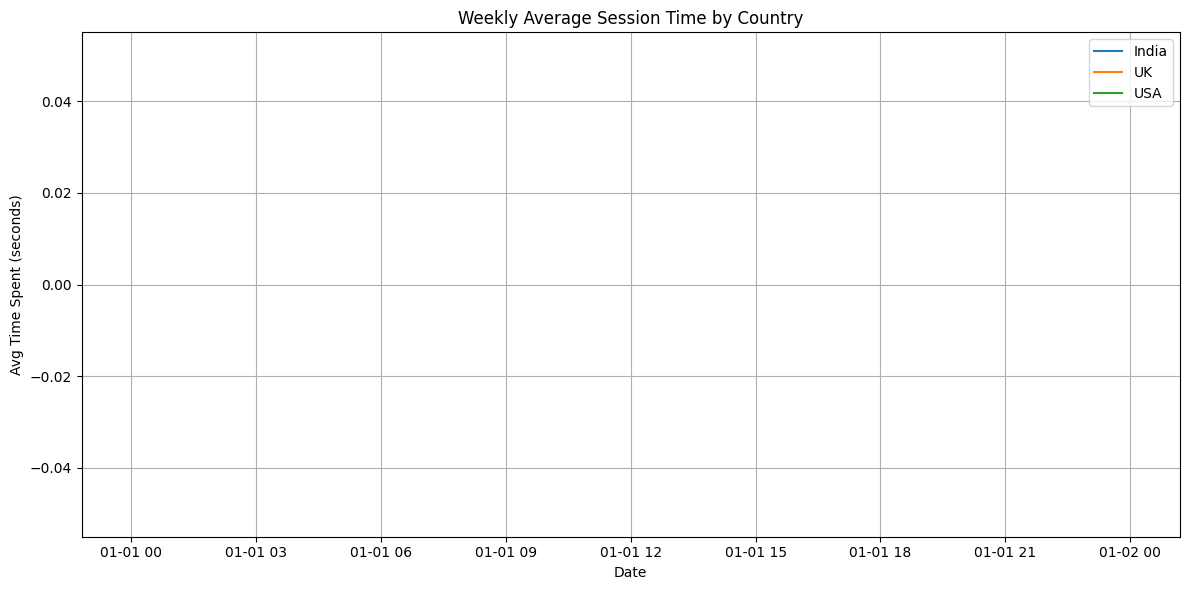

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv('web_traffic.csv', parse_dates=['Date'])

# 2. MultiIndexing with Country and Date
df.set_index(['Country', 'Date'], inplace=True)
df.sort_index(inplace=True)

# 3. Reshape data using melt() and unstack()
# Reset to use melt
df_reset = df.reset_index()

# Melt engagement metrics into long format
melted = pd.melt(df_reset, 
                 id_vars=['Country', 'Date', 'User ID'],
                 value_vars=['Page Views', 'Time Spent (seconds)', 'Bounce Rate (%)'],
                 var_name='Metric',
                 value_name='Value')

# Pivot for unstacking
pivot = df_reset.pivot_table(index=['Country', 'Date'], 
                             values=['Page Views', 'Time Spent (seconds)', 'Bounce Rate (%)'],
                             aggfunc='mean')

# Unstack Country (to compare countries side by side)
unstacked = pivot.unstack(level=0)

# 4. Rolling and Expanding Metrics

# Rolling: Weekly average session time (per country)
weekly_avg_time = df_reset.groupby('Country').apply(
    lambda x: x.set_index('Date')['Time Spent (seconds)'].rolling(window=7).mean()
).reset_index(level=0, drop=True)

# Expanding: Cumulative page views per country
cumulative_views = df_reset.groupby('Country').apply(
    lambda x: x.set_index('Date')['Page Views'].expanding().sum()
).reset_index(level=0, drop=True)

# Add to original df (reindex to match)
df_reset['Weekly Avg Time'] = weekly_avg_time.values
df_reset['Cumulative Views'] = cumulative_views.values

# 5. Compare Loop vs Vectorized for Bounce Rate Change

# Vectorized
df_reset['Bounce Rate Change (%)'] = df_reset.groupby('Country')['Bounce Rate (%)'].diff()

# Loop (for educational comparison)
df_reset['Loop Bounce Change'] = 0.0
for country in df_reset['Country'].unique():
    bounce_rates = df_reset[df_reset['Country'] == country]['Bounce Rate (%)'].values
    bounce_change = [0.0] + [bounce_rates[i] - bounce_rates[i-1] for i in range(1, len(bounce_rates))]
    df_reset.loc[df_reset['Country'] == country, 'Loop Bounce Change'] = bounce_change

# 6. Use apply() instead of iterrows()

# Example: Categorize session quality based on time spent
def classify_session(row):
    if row['Time Spent (seconds)'] > 300:
        return 'High'
    elif row['Time Spent (seconds)'] > 120:
        return 'Medium'
    else:
        return 'Low'

df_reset['Session Quality'] = df_reset.apply(classify_session, axis=1)

# 7. Visualizations using Matplotlib

plt.figure(figsize=(12, 6))

# Line plot: Weekly Avg Time per country
for country in df_reset['Country'].unique():
    data = df_reset[df_reset['Country'] == country]
    plt.plot(data['Date'], data['Weekly Avg Time'], label=country)

plt.title('Weekly Average Session Time by Country')
plt.xlabel('Date')
plt.ylabel('Avg Time Spent (seconds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
